
- input data
    1. raw data 1sec window / 1hop, 2hop, 3hop concatenate
    2. raw data 5sec window / 1hop, 2hop, 3hop concatenate
    3. hidden feature from 파악 task 5sec window RNN model / 1hop, 2hop, 3hop, concatenate
    
- model
    1. FNN
    2. LSTM
    3. LSTM + 0hop

simulation map
<img src="./map.png" width=500/>

sensorData_x.txt is made from region x in above map

# Prepare data for prediction task

In [ ]:
# import modules
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
import keras.backend.tensorflow_backend as K
from keras.utils import plot_model
from IPython.display import Image, display
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt


In [2]:
# load data to memory
num_region = 8
data = dict()
for i in range(1, 1+num_region):
    filename = './data/sensorData_{}.txt'.format(i)
    curr = np.loadtxt(filename, delimiter=',')
    print(filename, 'type:', type(curr), 'shape:', curr.shape)
    data[i] = curr

./data/sensorData_1.txt type: <class 'numpy.ndarray'> shape: (160000, 9)
./data/sensorData_2.txt type: <class 'numpy.ndarray'> shape: (160000, 9)
./data/sensorData_3.txt type: <class 'numpy.ndarray'> shape: (160000, 9)
./data/sensorData_4.txt type: <class 'numpy.ndarray'> shape: (160000, 9)
./data/sensorData_5.txt type: <class 'numpy.ndarray'> shape: (160000, 9)
./data/sensorData_6.txt type: <class 'numpy.ndarray'> shape: (160000, 9)
./data/sensorData_7.txt type: <class 'numpy.ndarray'> shape: (160000, 9)
./data/sensorData_8.txt type: <class 'numpy.ndarray'> shape: (160000, 9)


In [3]:
# 사람숫자 => label로 변경
# 0 -> 0
# 1~3 -> 1
# 4~6 -> 2
# 7~ -> 3
def apply_label(data_dict):
    bins = np.array([1, 4, 7])
    for i in range(1, 1+num_region):
        curr = data_dict[i]
        inds = np.digitize(curr[:, 0], bins)
        curr[:, 0] = inds

In [4]:
# apply label and show its distribution
apply_label(data)
for i in range(1, 1+num_region):
    curr = data[i]
    labels = [0, 0, 0, 0]
    for row in curr:
        if row[0] == 0:
            labels[0] += 1
        elif row[0] == 1:
            labels[1] += 1
        elif row[0] == 2:
            labels[2] += 1
        elif row[0] == 3:
            labels[3] += 1
        
    print('sensorData_{}:'.format(i), labels)

sensorData_1: [105088, 27770, 15636, 11506]
sensorData_2: [127663, 19239, 9150, 3948]
sensorData_3: [104611, 28354, 15521, 11514]
sensorData_4: [148387, 6924, 3269, 1420]
sensorData_5: [128714, 17147, 8651, 5488]
sensorData_6: [142811, 10356, 4735, 2098]
sensorData_7: [98714, 30894, 17381, 13011]
sensorData_8: [122549, 21877, 10782, 4792]


In [5]:
# return current graph topology
def get_adj_matrix():
    arr = [[0]*8 for x in range(8)]
    for i in range(8):
        before, after = (i-1)%8, (i+1)%8
        arr[i][before] = 1
        arr[i][after] = 1
        
    return arr

In [6]:
for row in get_adj_matrix():
    print(row)

[0, 1, 0, 0, 0, 0, 0, 1]
[1, 0, 1, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 0, 0, 0, 0]
[0, 0, 1, 0, 1, 0, 0, 0]
[0, 0, 0, 1, 0, 1, 0, 0]
[0, 0, 0, 0, 1, 0, 1, 0]
[0, 0, 0, 0, 0, 1, 0, 1]
[1, 0, 0, 0, 0, 0, 1, 0]


In [7]:
# return distance matrix
# using Floyd-Warshall
# use this when calculate n-hop avg
def get_distance_matrix(adj_matrix):
    result = [row for row in adj_matrix]
    N = len(result)
    
    for i in range(N):
        for j in range(N):
            if i != j and result[i][j] == 0:
                result[i][j] = 8
    
    for k in range(N):
        for i in range(N):
            for j in range(N):
                result[i][j] = min(result[i][j], result[i][k] + result[k][j])
                    
    return result

In [8]:
for row in get_distance_matrix(get_adj_matrix()):
    print(row)

[0, 1, 2, 3, 4, 3, 2, 1]
[1, 0, 1, 2, 3, 4, 3, 2]
[2, 1, 0, 1, 2, 3, 4, 3]
[3, 2, 1, 0, 1, 2, 3, 4]
[4, 3, 2, 1, 0, 1, 2, 3]
[3, 4, 3, 2, 1, 0, 1, 2]
[2, 3, 4, 3, 2, 1, 0, 1]
[1, 2, 3, 4, 3, 2, 1, 0]


In [9]:
def get_nhop_index(dist_matrix, src, hop):
    result = []
    for i, dist in enumerate(dist_matrix[src-1]):
        if dist == hop:
            result.append(i+1) # node index는 1기준, list index는 0기준이므로 맞춰줌
            
    return result

In [10]:
def get_nhop_avg(data, dist_matrix, src, hop, num_frame):
    idxs = get_nhop_index(dist_matrix, src, hop)
    N = data[1]['x'].shape[0] # batch size
    NUM_FRAME = num_frame
    result = np.zeros((N, NUM_FRAME, 8), dtype=np.float32)
    for i in idxs:
        result += data[i]['x']
        
    result /= len(idxs)
    return result

In [11]:
# data: raw data
# result[sensor_idx]['x'] = data, shape: (N-DATA_WINDOW-PRED_WINDOW, DATA_WINDOW, 8)
# result[sensor_idx]['y'] = label, shape: (N-DATA_WINDOW-PRED_WINDOW, 1)
def get_window(data, n_sec):
    result = dict()
    N = data[1].shape[0] # number of row(160000)
    DATA_WINDOW = n_sec*8 # 1second window
    PRED_WINDOW = 160 # predict after 20 seconds
    for i in range(1, 9):
        result[i] = dict()
        result[i]['x'] = np.zeros((N-DATA_WINDOW-PRED_WINDOW+1, DATA_WINDOW, 8))
        result[i]['y'] = np.zeros((N-DATA_WINDOW-PRED_WINDOW+1))
        curr = data[i]
        
        # iterate over row
        for j in range(N-DATA_WINDOW-PRED_WINDOW+1):
            result[i]['x'][j] = curr[j:j+DATA_WINDOW, 1:] # data
            result[i]['y'][j] = curr[j+DATA_WINDOW+PRED_WINDOW-1, 0] # label
            
        # balance between # of labels
        NUM_MIN_LABEL = 1420 # manually calculated, sensorData_4
        idx0 = result[i]['y'] == 0
        idx1 = result[i]['y'] == 1
        idx2 = result[i]['y'] == 2
        idx3 = result[i]['y'] == 3
        
        result[i]['x'] = np.concatenate([
            result[i]['x'][idx0][:NUM_MIN_LABEL],
            result[i]['x'][idx1][:NUM_MIN_LABEL],
            result[i]['x'][idx2][:NUM_MIN_LABEL],
            result[i]['x'][idx3][:NUM_MIN_LABEL],
        ], axis=0)
        result[i]['y'] = np.concatenate([
            result[i]['y'][idx0][:NUM_MIN_LABEL],
            result[i]['y'][idx1][:NUM_MIN_LABEL],
            result[i]['y'][idx2][:NUM_MIN_LABEL],
            result[i]['y'][idx3][:NUM_MIN_LABEL],

        ], axis=0)
            
    return result

# Model

In [12]:
class FNN():
    def __init__(self, input_dim):
        model = Sequential()
        model.add(Dense(64, input_dim=input_dim))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        model.add(Dense(128))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        model.add(Dense(64))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        model.add(Dense(4)) # output layer
        model.add(BatchNormalization())
        model.add(Activation('softmax'))
        
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model = model
        
    def fit(self, x, y, epochs, batch_size):
        return self.model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_split=0.25, verbose=0)
        
    def evaluate(self, x, y, batch_size=256):
        return self.model.evaluate(x, y, batch_size=batch_size)
        


In [18]:
class LSTM_net():
    def __init__(self, timesteps, input_dim):
        model = Sequential()
        
        model.add(LSTM(128, return_sequences=True, input_shape=(timesteps, input_dim)))
        model.add(BatchNormalization())
        
        model.add(LSTM(128, return_sequences=True))
        model.add(BatchNormalization())
        
        model.add(LSTM(32))
        model.add(BatchNormalization())
        
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        model.add(Dense(4))
        model.add(BatchNormalization())
        model.add(Activation('softmax'))
        
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model = model
        
    def fit(self, x, y, epochs, batch_size):
        return self.model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_split=0.25, verbose=1)
        
    def evaluate(self, x, y, batch_size=256):
        return self.model.evaluate(x, y, batch_size=batch_size)

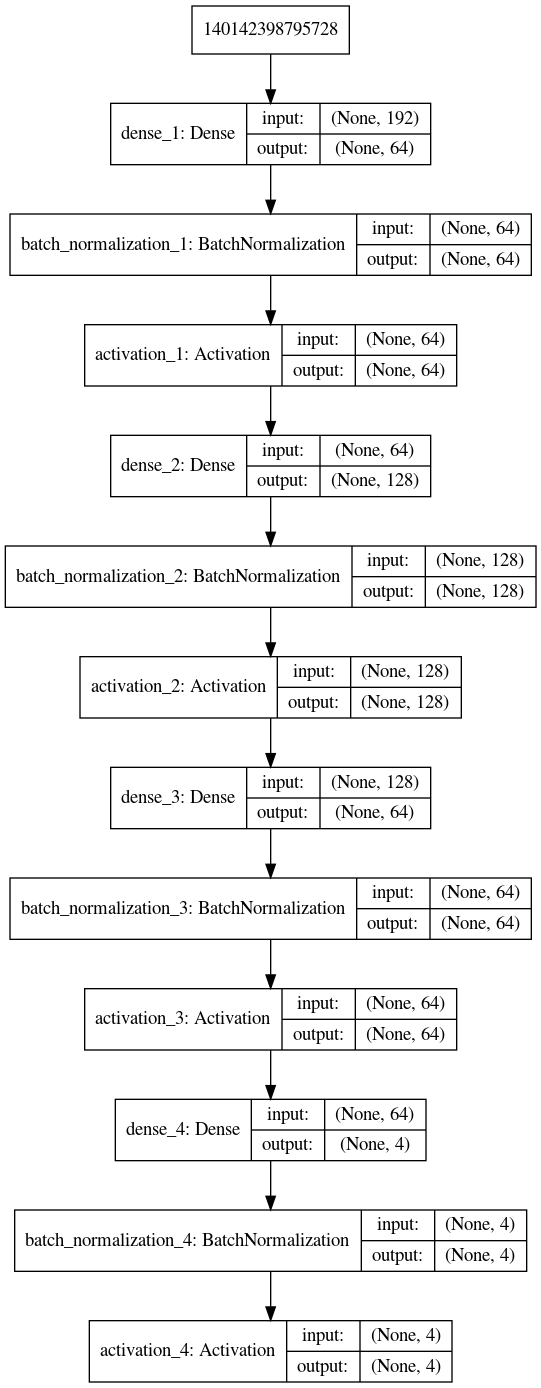

x.shape: (45440, 192)
y.shape: (45440, 4)
9088/9088 [==============================] - 0s 14us/step


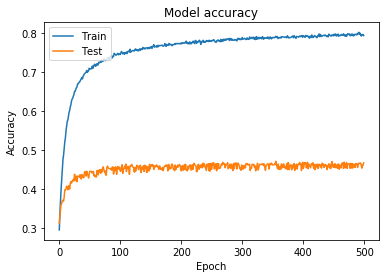

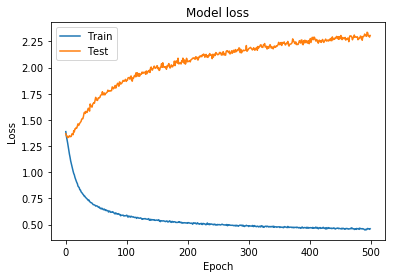

test accuracy: 0.4574163732394366


In [14]:
##### FNN with 1sec window
def FNN_raw_1sec():
    window_1sec = get_window(data, 1)
    N = window_1sec[1]['x'].shape[0]
    NUM_FRAME = 8 # 1sec
    NUM_CLASSES = 4
    adj_matrix = get_adj_matrix()
    dist_matrix = get_distance_matrix(adj_matrix)
    model = FNN(NUM_FRAME*8*3)
    
    # visualize graph
    plot_model(model.model, show_shapes=True, to_file='FNN_raw_1sec.png')
    display(Image(filename='FNN_raw_1sec.png'))

    
    x = None
    y = None
    
    # node별 hop을 적용하여 x, y data를 만들어줌
    for i in range(1, 9):
        hop1 = get_nhop_avg(window_1sec, dist_matrix, src=i, hop=1, num_frame=NUM_FRAME)
        hop2 = get_nhop_avg(window_1sec, dist_matrix, src=i, hop=2, num_frame=NUM_FRAME)
        hop3 = get_nhop_avg(window_1sec, dist_matrix, src=i, hop=3, num_frame=NUM_FRAME)
        curr_x = np.concatenate((hop1, hop2, hop3), axis=2) # shape: (N, num_frame, 8*3)
        curr_x = np.reshape(curr_x, (N, NUM_FRAME*8*3)) # shape: (N, num_frame*8*3)
        curr_y = window_1sec[i]['y'] # shape: (N, 1)
        curr_y = curr_y.reshape(-1).astype(np.int32)
        curr_y = np.eye(NUM_CLASSES)[curr_y] # one-hot encoding

        if x is None:
            x = curr_x
            y = curr_y
        else:
            x = np.concatenate((x, curr_x), axis=0)
            y = np.concatenate((y, curr_y), axis=0)

    print('x.shape:', x.shape)
    print('y.shape:', y.shape)
            
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) # random_state: seed 번호를 지정해서 매번 같은 split 이루어지도록
    history = model.fit(x_train, y_train, epochs=500, batch_size=128)
    loss, accuracy = model.evaluate(x_test, y_test, batch_size=128)

    
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    print('test accuracy:', accuracy)
        
FNN_raw_1sec()        

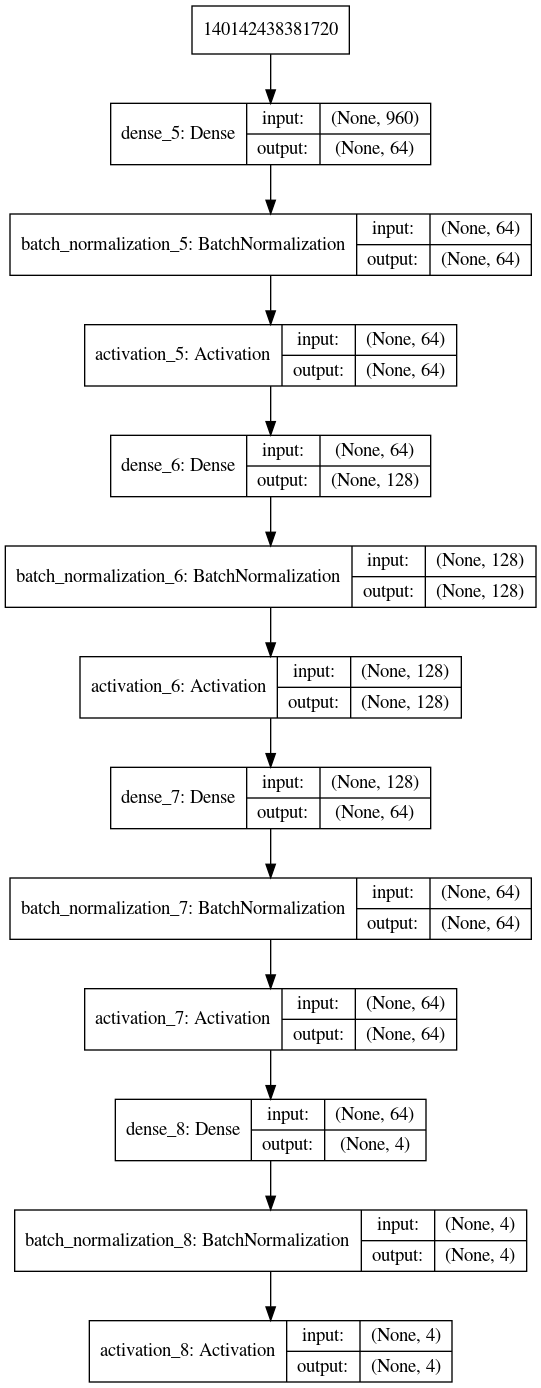

x.shape: (45440, 960)
y.shape: (45440, 4)
9088/9088 [==============================] - 0s 17us/step


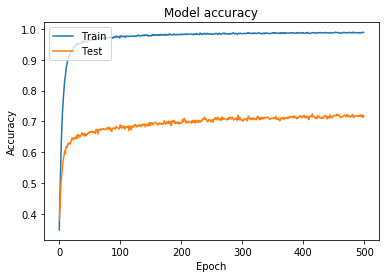

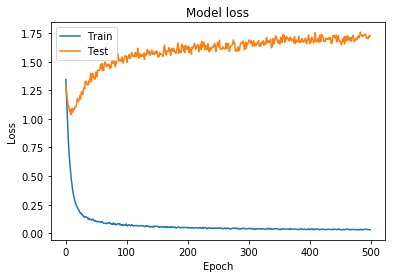

test accuracy: 0.7194102112676056


In [15]:
##### FNN with 5sec window
def FNN_raw_5sec():
    window_5sec = get_window(data, 5)
    N = window_5sec[1]['x'].shape[0]
    NUM_FRAME = 40 # 5sec
    NUM_CLASSES = 4
    adj_matrix = get_adj_matrix()
    dist_matrix = get_distance_matrix(adj_matrix)
    model = FNN(NUM_FRAME*8*3)

    # visualize graph
    plot_model(model.model, show_shapes=True, to_file='FNN_raw_5sec.png')
    display(Image(filename='FNN_raw_5sec.png'))
    
    x = None
    y = None
    
    # node별 hop을 적용하여 x, y data를 만들어줌
    for i in range(1, 9):
        hop1 = get_nhop_avg(window_5sec, dist_matrix, src=i, hop=1, num_frame=NUM_FRAME)
        hop2 = get_nhop_avg(window_5sec, dist_matrix, src=i, hop=2, num_frame=NUM_FRAME)
        hop3 = get_nhop_avg(window_5sec, dist_matrix, src=i, hop=3, num_frame=NUM_FRAME)
        curr_x = np.concatenate((hop1, hop2, hop3), axis=2) # shape: (N, num_frame, 8*3)
        curr_x = np.reshape(curr_x, (N, NUM_FRAME*8*3)) # shape: (N, num_frame*8*3)
        curr_y = window_5sec[i]['y'] # shape: (N, 1)
        curr_y = curr_y.reshape(-1).astype(np.int32)
        curr_y = np.eye(NUM_CLASSES)[curr_y] # one-hot encoding

        if x is None:
            x = curr_x
            y = curr_y
        else:
            x = np.concatenate((x, curr_x), axis=0)
            y = np.concatenate((y, curr_y), axis=0)

    print('x.shape:', x.shape)
    print('y.shape:', y.shape)
            
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) # random_state: seed 번호를 지정해서 매번 같은 split 이루어지도록
    history = model.fit(x_train, y_train, epochs=500, batch_size=128)
    loss, accuracy = model.evaluate(x_test, y_test, batch_size=128)
    
    
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    print('test accuracy:', accuracy)
        
FNN_raw_5sec()        

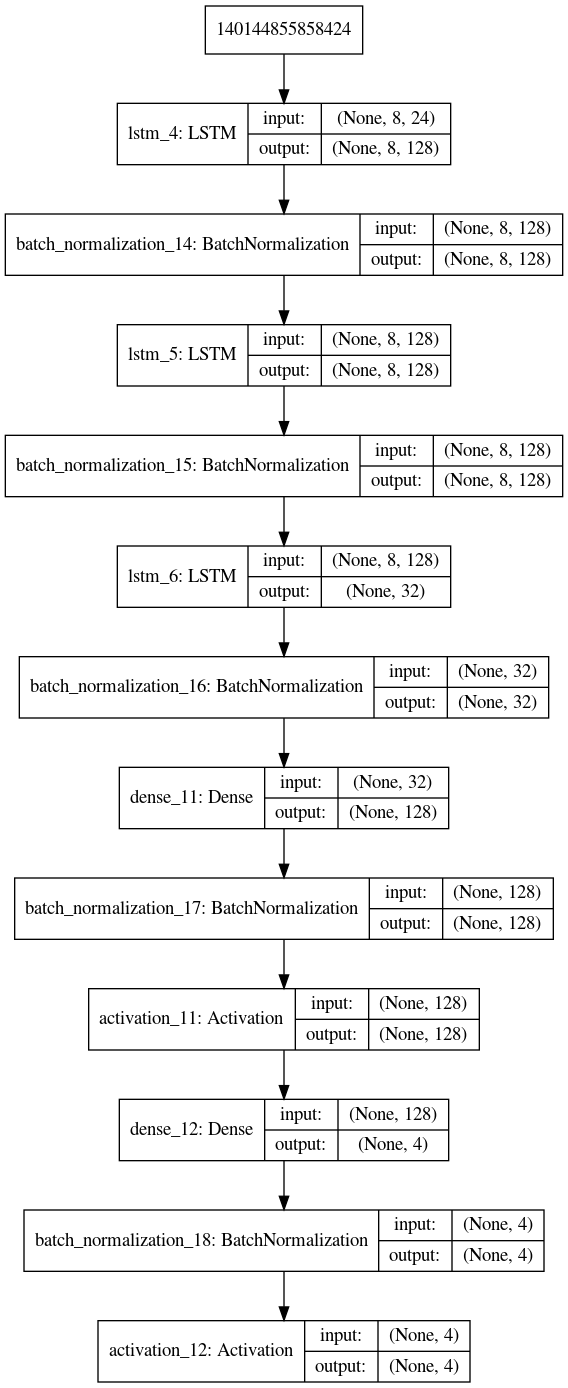

x.shape: (45440, 8, 24)
y.shape: (45440, 4)
Train on 27264 samples, validate on 9088 samples
Epoch 1/500
27264/27264 [==============================] - 12s 436us/step - loss: 1.3942 - acc: 0.3001 - val_loss: 1.3619 - val_acc: 0.3182
Epoch 2/500
27264/27264 [==============================] - 8s 283us/step - loss: 1.3398 - acc: 0.3481 - val_loss: 1.3583 - val_acc: 0.3271
Epoch 3/500
27264/27264 [==============================] - 8s 285us/step - loss: 1.3184 - acc: 0.3636 - val_loss: 1.3285 - val_acc: 0.3502
Epoch 4/500
27264/27264 [==============================] - 8s 284us/step - loss: 1.2887 - acc: 0.3842 - val_loss: 1.3066 - val_acc: 0.3818
Epoch 5/500
27264/27264 [==============================] - 8s 283us/step - loss: 1.2490 - acc: 0.4181 - val_loss: 1.2874 - val_acc: 0.3897
Epoch 6/500
27264/27264 [==============================] - 8s 287us/step - loss: 1.2036 - acc: 0.4461 - val_loss: 1.2703 - val_acc: 0.4092
Epoch 7/500
27264/27264 [==============================] - 8s 281us/step

Epoch 59/500
27264/27264 [==============================] - 8s 283us/step - loss: 0.4249 - acc: 0.8062 - val_loss: 1.0947 - val_acc: 0.6438
Epoch 60/500
27264/27264 [==============================] - 8s 285us/step - loss: 0.4228 - acc: 0.8062 - val_loss: 1.0924 - val_acc: 0.6456
Epoch 61/500
27264/27264 [==============================] - 8s 280us/step - loss: 0.4212 - acc: 0.8058 - val_loss: 1.0899 - val_acc: 0.6361
Epoch 62/500
27264/27264 [==============================] - 8s 280us/step - loss: 0.4108 - acc: 0.8103 - val_loss: 1.0998 - val_acc: 0.6440
Epoch 63/500
27264/27264 [==============================] - 8s 285us/step - loss: 0.4181 - acc: 0.8107 - val_loss: 1.1144 - val_acc: 0.6327
Epoch 64/500
27264/27264 [==============================] - 8s 284us/step - loss: 0.4155 - acc: 0.8085 - val_loss: 1.1152 - val_acc: 0.6372
Epoch 65/500
27264/27264 [==============================] - 8s 285us/step - loss: 0.4143 - acc: 0.8082 - val_loss: 1.1041 - val_acc: 0.6359
Epoch 66/500
27264/2

In [ ]:
##### LSTM with 1sec window
def LSTM_raw_1sec():
    window_1sec = get_window(data, 1)
    N = window_1sec[1]['x'].shape[0]
    timesteps = NUM_FRAME = 8 # 1sec
    input_dim = 8*3 # concatenate over 3 kinds of hops
    NUM_CLASSES = 4
    adj_matrix = get_adj_matrix()
    dist_matrix = get_distance_matrix(adj_matrix)
    model = LSTM_net(timesteps, input_dim)

    # visualize graph
    plot_model(model.model, show_shapes=True, to_file='LSTM_raw_1sec.png')
    display(Image(filename='LSTM_raw_1sec.png'))
    
    x = None
    y = None
    
    # node별 hop을 적용하여 x, y data를 만들어줌
    for i in range(1, 9):
        hop1 = get_nhop_avg(window_1sec, dist_matrix, src=i, hop=1, num_frame=NUM_FRAME)
        hop2 = get_nhop_avg(window_1sec, dist_matrix, src=i, hop=2, num_frame=NUM_FRAME)
        hop3 = get_nhop_avg(window_1sec, dist_matrix, src=i, hop=3, num_frame=NUM_FRAME)
        curr_x = np.concatenate((hop1, hop2, hop3), axis=2) # shape: (N, num_frame, 8*3)
        curr_y = window_1sec[i]['y'] # shape: (N, 1)
        curr_y = curr_y.reshape(-1).astype(np.int32)
        curr_y = np.eye(NUM_CLASSES)[curr_y] # one-hot encoding

        if x is None:
            x = curr_x
            y = curr_y
        else:
            x = np.concatenate((x, curr_x), axis=0)
            y = np.concatenate((y, curr_y), axis=0)

    print('x.shape:', x.shape)
    print('y.shape:', y.shape)
            
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) # random_state: seed 번호를 지정해서 매번 같은 split 이루어지도록
    history = model.fit(x_train, y_train, epochs=500, batch_size=128)
    loss, accuracy = model.evaluate(x_test, y_test, batch_size=128)
    
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    print('test accuracy:', accuracy)
        
LSTM_raw_1sec()        

In [ ]:
##### LSTM with 5sec window
def LSTM_raw_5sec():
    window_5sec = get_window(data, 5)
    N = window_5sec[1]['x'].shape[0]
    timesteps = NUM_FRAME = 40 # 5sec
    input_dim = 8*3 # concatenate over 3 kinds of hops
    NUM_CLASSES = 4
    adj_matrix = get_adj_matrix()
    dist_matrix = get_distance_matrix(adj_matrix)
    model = LSTM_net(timesteps, input_dim)

    # visualize graph
    plot_model(model.model, show_shapes=True, to_file='FNN_raw_5sec.png')
    display(Image(filename='FNN_raw_5sec.png'))
    
    x = None
    y = None
    
    # node별 hop을 적용하여 x, y data를 만들어줌
    for i in range(1, 9):
        hop1 = get_nhop_avg(window_5sec, dist_matrix, src=i, hop=1, num_frame=NUM_FRAME)
        hop2 = get_nhop_avg(window_5sec, dist_matrix, src=i, hop=2, num_frame=NUM_FRAME)
        hop3 = get_nhop_avg(window_5sec, dist_matrix, src=i, hop=3, num_frame=NUM_FRAME)
        curr_x = np.concatenate((hop1, hop2, hop3), axis=2) # shape: (N, num_frame, 8*3)
        curr_y = window_5sec[i]['y'] # shape: (N, 1)
        curr_y = curr_y.reshape(-1).astype(np.int32)
        curr_y = np.eye(NUM_CLASSES)[curr_y] # one-hot encoding

        if x is None:
            x = curr_x
            y = curr_y
        else:
            x = np.concatenate((x, curr_x), axis=0)
            y = np.concatenate((y, curr_y), axis=0)

    print('x.shape:', x.shape)
    print('y.shape:', y.shape)
            
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) # random_state: seed 번호를 지정해서 매번 같은 split 이루어지도록
    history = model.fit(x_train, y_train, epochs=500, batch_size=128)
    loss, accuracy = model.evaluate(x_test, y_test, batch_size=128)
    
    
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    print('test accuracy:', accuracy)
        
LSTM_raw_5sec()        

In [ ]:
print('hi')